In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import timm
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns

### Model Definition

In [13]:
# CNN Model Definition
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        # Convolutional Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional Block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(16 * 28 * 28, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.3)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.3)
        )

        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

# ResNet Model Definition
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()
        # Load pretrained ResNet50
        self.resnet = models.resnet50(pretrained=True)

        # Replace the final fully connected layer
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# EfficientNet-Lite Model Definition
class EfficientNetLiteClassifier(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetLiteClassifier, self).__init__()
        # EfficientNet-Lite model from timm
        self.efficientnet_lite = timm.create_model('efficientnet_lite0', pretrained=True)
        self.efficientnet_lite.classifier = nn.Linear(self.efficientnet_lite.classifier.in_features, num_classes)

    def forward(self, x):
        return self.efficientnet_lite(x)

### Load Test Data

In [14]:
# Define directories
dataset_path = "Lung Disease Dataset"
test_dir = f"{dataset_path}/test"
val_dir = f"{dataset_path}/val"  # Validation directory

# Image size and batch size
image_size = (224, 224)
batch_size = 32

# Define transformations for test and validation data
common_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4876, 0.4976, 0.5008], std=[0.2203, 0.2228, 0.2241])
])

# Load the test dataset
test_dataset = datasets.ImageFolder(test_dir, transform=common_transform)

# Load the validation dataset (to be used for stacking training)
val_dataset = datasets.ImageFolder(val_dir, transform=common_transform)

# DataLoader for the test and validation datasets
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


### Load Models

In [15]:
# Load each model and its weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 5
CNN_model = CNN(num_classes=num_classes).to(device)
CNN_model.load_state_dict(torch.load("CNN_model.pth"))

ResNet_model = ResNetClassifier(num_classes=num_classes).to(device)
ResNet_model.load_state_dict(torch.load("ResNet_model.pth"))

EfficientNet_model = EfficientNetLiteClassifier(num_classes=num_classes).to(device)
EfficientNet_model.load_state_dict(torch.load("EfficientNet_model.pth"))

C:\Users\zifon\AppData\Local\Temp\ipykernel_8256\338947385.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CNN_model.load_state_dict(torch.load("CNN_model.pth"))
c:\User

<All keys matched successfully>

### Generate and Save Probabilities

In [16]:
# Generate probabilities for the test and validation data
def generate_probabilities(model, data_loader, device):
    model.eval()
    probabilities = []

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            probabilities.append(probs.cpu().numpy())

    return np.vstack(probabilities)

# Generate probabilities for the test dataset
CNN_test_probs = generate_probabilities(CNN_model, test_loader, device)
ResNet_test_probs = generate_probabilities(ResNet_model, test_loader, device)
EfficientNet_test_probs = generate_probabilities(EfficientNet_model, test_loader, device)

# Save test probabilities to .npy files
np.save("test_probs_CNN.npy", CNN_test_probs)
np.save("test_probs_ResNet.npy", ResNet_test_probs)
np.save("test_probs_EfficientNet.npy", EfficientNet_test_probs)

# Generate probabilities for the validation dataset (to train stacking model)
CNN_val_probs = generate_probabilities(CNN_model, val_loader, device)
ResNet_val_probs = generate_probabilities(ResNet_model, val_loader, device)
EfficientNet_val_probs = generate_probabilities(EfficientNet_model, val_loader, device)

# Save validation probabilities to .npy files
np.save("val_probs_CNN.npy", CNN_val_probs)
np.save("val_probs_ResNet.npy", ResNet_val_probs)
np.save("val_probs_EfficientNet.npy", EfficientNet_val_probs)


### Combine Probabilities for Stacking

Stacking Accuracy: 0.9146
Classification Report (Stacking):
              precision    recall  f1-score   support

           0     0.8308    0.8164    0.8235       403
           1     0.9975    0.9926    0.9951       407
           2     0.9385    0.9827    0.9601       404
           3     0.9976    1.0000    0.9988       408
           4     0.8010    0.7792    0.7899       403

    accuracy                         0.9146      2025
   macro avg     0.9131    0.9142    0.9135      2025
weighted avg     0.9135    0.9146    0.9139      2025



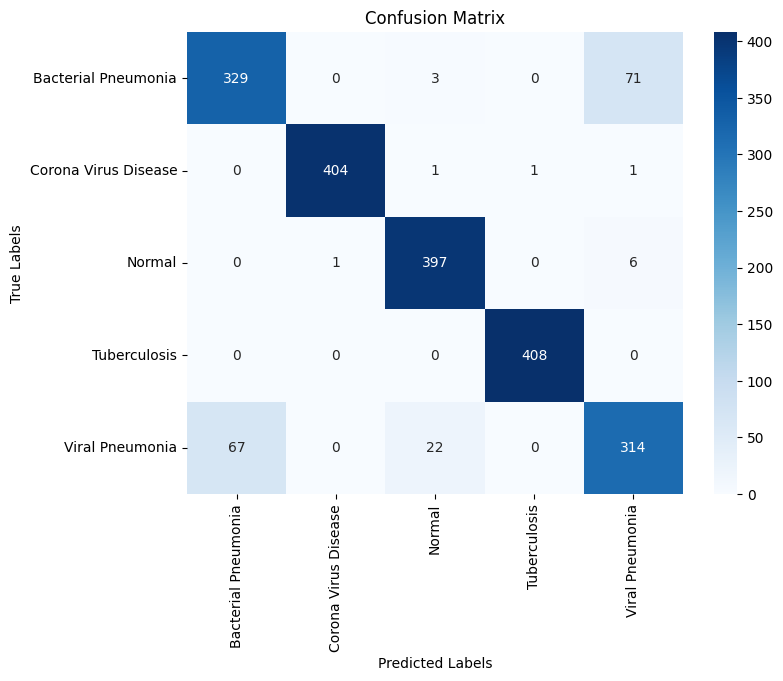

In [17]:
# Load true labels for the validation dataset (used for stacking model training)
val_labels = np.array([label for _, label in val_dataset])

# Stacking ensemble using validation data for training
stacking_features = np.hstack([CNN_val_probs, ResNet_val_probs, EfficientNet_val_probs])

# Train the meta-model (Logistic Regression) on validation data
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(stacking_features, val_labels)

# Generate predictions using the test dataset
test_stacking_features = np.hstack([CNN_test_probs, ResNet_test_probs, EfficientNet_test_probs])
stacking_predictions = meta_model.predict(test_stacking_features)

# Load true labels for the test dataset (used for evaluation)
true_labels = np.array([label for _, label in test_dataset])

# Evaluate the stacking model on the test dataset
accuracy = accuracy_score(true_labels, stacking_predictions)
print(f"Stacking Accuracy: {accuracy:.4f}")

report = classification_report(true_labels, stacking_predictions, digits=4)
print("Classification Report (Stacking):")
print(report)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, stacking_predictions)

# Display confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Class names (adjust based on your dataset)
class_names = test_dataset.classes

# Plot the confusion matrix
plot_confusion_matrix(conf_matrix, class_names)
